# Cooking ingredients recommendation
This notebook builds a recommendation system for cooking ingredients using. The end goal is to build a recommendation system that takes as input a list of existing ingredients and outputs a collection of ingredients that would go well with the existing ingredients. 

<b> Notebook contents </b>
0. load and clean data  
1. Preliminary analysis
2. Non-negative matrix factorizations
3. Word-embeddings
4. Association rule mining  
5. Comparison of models
6. Future directions / To Do 

***NOTE:*** *This is project is in progress.*



In [1]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages')

In [1]:
# conda environment "recipes"
# Python standard libraries
import ast 
import csv
import os
import pickle
import random
import re
import statistics
import time
from collections import Counter 
from itertools import combinations



In [2]:
import functions as fn

In [3]:


# Third party imports 
import gensim
import h5py
import ijson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from efficient_apriori import apriori
from gensim.models import Word2Vec
from gensim.models.nmf import Nmf
from gensim.corpora import Dictionary
from matplotlib import style
plt.style.use('ggplot')
from sklearn.decomposition import NMF, PCA


In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Lambda, Dense
import tensorflow.keras.backend as K

In [6]:
from tensorflow import keras

In [7]:
def sample_ingredients(ing, n_samples):  
    # For each recipe, sample "n_samples" number of ingredients randomly.
    # (If a recipe involves fewer than "n_samples" ingredients, ignore that recipe)
    # The sampled ingredients will function as the existing ingredients
    # Goal of the model is to predict the remaining ingredients that
    # have not been sampled
    
    """
    --- input ---
    ing: (list of lists) Each item of ing is a list of ingredients 
           for a particular recipe
    n_samples: (int) number of ingredients to be sampled
   
    --- output ---
    existing_ing: (list of lists) Each item of sampled_ing is a list of 
            ingredients that have been sampled
    missing_ing: (list of lists) Each item of remaining_ing is a list of ingredients
            that have not been sampled
    """
    
    existing_ing = []
    missing_ing = []
    indices = []
    for idx, recipe in enumerate(ing):
        if len(recipe) > n_samples:
            # randomly select 5 ingredients
            sampled = random.sample(recipe, n_samples)
            remain = list(set(recipe)-set(sampled))

            existing_ing.append(sampled)
            missing_ing.append(remain)
            indices.append(idx)
    return existing_ing, missing_ing, indices


In [8]:
def compute_scores(predicted_ing, true_ing):
    """
    predicted_ing: (list) of predicted ingredients from the model
    true_ing: (list) of true ingredients that needed to be predicted
    """
    
    predicted_ing = set(predicted_ing)
    true_ing = set(true_ing)

    TP = len(predicted_ing.intersection(true_ing))

    if len(predicted_ing) != 0:
        precision = TP / (len(predicted_ing))
    else:
        precision = 0 
    recall = TP / len(true_ing)
    
    if recall != 0 and precision != 0:
        F_score = (2 * recall * precision)/(precision + recall)
    else:
        F_score = 0
    
    return precision, recall, F_score


In [7]:
# example 
precision, recall, F_score = compute_scores(['onions', 'scallions', 'bread'],
                                           ['scallions'])

print('precision: ' , precision)
print('recall: ', recall)
print('F_score: ', F_score)

precision:  0.3333333333333333
recall:  1.0
F_score:  0.5


# Multi-label classification via neural networks

In [9]:
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = list(np.unique(df.cuisine))

# Convert to correct format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

# randomly shuffle the order of ingredients in each document
for item in documents:
    random.shuffle(item)
    
# load train, cv, test data index
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
train_idx = list(f.get("train_idx"))
cv_idx = list(f.get("cv_idx"))
test_idx = list(f.get("test_idx"))
f.close()

train_doc = [documents[i] for i in train_idx]
cv_doc = [documents[i] for i in cv_idx]

In [11]:
# tokenize
#t=Tokenizer()  
#t.fit_on_texts(documents)

# save tokenizer
#with open('models/multilabel_tokenizer.pickle', 'wb') as handle:
#    pickle.dump(t, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
# load tokenizer
with open('models/multilabel_tokenizer.pickle', 'rb') as handle:
    t = pickle.load(handle)

encoded_recipes=t.texts_to_sequences(documents)

# create reverse dictionary from index to words 
index_to_words=dict(map(reversed,t.word_index.items())) 

# number of words
n_words = len(t.word_index)
print('number of words: ', n_words)

number of words:  6712


# Prepare dataset

In [83]:
def create_Xy(doc, t, sample_size, n_repeat = 1):
    # Given a list of documents, sample "sample_size" number of ingredients from each document. 
    # Create arrays X and y for neural network training and testing.
    # If a document contains less than "sample_size" ingredients, then skip that document.
    
    """
    --- input ---
    doc: (list of lists) Each doc[i] is a document given by a list of ingredients
    t: (tokenizer)
    sample_size: (int) number of ingredients to sample from each doc
    n_repeat: (int) number of times to perform the sampling.
    
    --- output ---
    X: (array) representing the ingredients sampled for each document
        X[i][j] = 1 if sampled ingredients of doc[i] contains ingredient j (according to tokenizer t)
    y: (array) representing the ingredients NOT sampled
        y[i][j] = 1 if ingredient j is present in doc[i] but was not sampled
    sample: (list of list) representing the ingredients sampled for each document.
        sample[i] = [i_1, ... , i_k], where i_j is an ingredient sampled for doc[i]
    target: (list of list) representing the ingredients in doc[i] that have not been sampled.
        target[i] = [i_1, ... , i_m], where i_m is an ingredient that hasn't been sampled
    """
    
    sample = []
    target = []
    indices = []
    n_doc = len(doc)
    encoded_doc = t.texts_to_sequences(doc)
    
    for i in range(n_doc):
        recipe = encoded_doc[i]
        
        # check that recipe contains more than "sample_size" ingredients
        if len(recipe) > sample_size:
            for j in range(n_repeat):
                random.shuffle(recipe)

                # split to sample & target
                recipe_sample = recipe[:sample_size]
                recipe_target = recipe[sample_size:]

                # adjust index to start at 0. This is because tokenizer starts index at 0
                recipe_sample = [item-1 for item in recipe_sample]
                recipe_target = [item-1 for item in recipe_target]

                # append
                sample.append(recipe_sample)
                target.append(recipe_target)
                indices.append(i)
            
    # create array X, y
    n_words = len(t.word_index)
    
    X = np.array(sample)
    y = np.zeros((len(target), n_words))
    
    for data_idx, target_words in enumerate(target):
        for word_idx in target_words:
            y[data_idx, word_idx] = 1

    return X, y, sample, target, indices

In [84]:
# load balanced training set 
df_train = pd.read_csv('data/ingredient_recommendation/balanced_training.csv')
df_train.drop("Unnamed: 0", axis = 1, inplace = True)
df_train.head()

,id,cuisine,ingredients,document
0,25295,french,"['eggs', 'semisweet_chocolate', 'white_sugar',...","['eggs', 'semisweet_chocolate', 'white_sugar',..."
1,4810,chinese,"['spareribs', 'vegetable_oil', 'corn_starch', ...","['spareribs', 'vegetable_oil', 'corn_starch', ..."
2,3128,korean,"['soy_sauce', 'pork_loin', 'yellow_onion', 'mi...","['soy_sauce', 'pork_loin', 'yellow_onion', 'mi..."
3,19484,mexican,"['turbinado', 'kosher_salt', 'cod_fillets', 's...","['turbinado', 'kosher_salt', 'cod_fillets', 's..."
4,49410,southern_us,"['eggs', 'ground_black_pepper', 'paprika', 'sh...","['eggs', 'ground_black_pepper', 'paprika', 'sh..."


In [88]:
# get training documents
train_doc = [ast.literal_eval(df_train.document[idx]) for idx in range(df_train.shape[0])]

# Create X, y for training 
X_train, y_train, sample_train, target_train, indices_train = create_Xy(train_doc, t, 5, 5)

# Create X_cv, y_cv for evaluation on cross-validation set
X_cv, y_cv, sampled_cv, target_cv, indices_cv = create_Xy(cv_doc, t, 5, 1)

In [36]:
class MetricsAtK:
    def __init__(self, k):
        self.k = k

    def _prediction_tensor(self, y_pred):
        # Given tensor y_pred of floats (predicted probabilities), 
        # return a tensor of same shape with 1 in locations with "k" top probabilities. 
        y_pred = tf.convert_to_tensor(y_pred)
        topk_indices = tf.nn.top_k(y_pred, k = self.k, sorted = True).indices
        ii, _ = tf.meshgrid(tf.range(tf.shape(y_pred)[0]), tf.range(6), indexing='ij')
        index_tensor = tf.reshape(tf.stack([ii, topk_indices], axis=-1), shape=(-1, 2))
        index_tensor = tf.cast(index_tensor, tf.int64)
        n_nzero = tf.shape(index_tensor)[0]

        sparse = tf.SparseTensor(indices = index_tensor, values=tf.ones(n_nzero), dense_shape=tf.shape(y_pred, out_type=tf.dtypes.int64))
        sparse = tf.sparse.reorder(sparse)
        pred = tf.sparse.to_dense(sparse)
        pred = tf.cast(pred, tf.float32)

        return pred

    def _TP_at_k(self, y_true, y_pred):
        y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
        # compute true positives for each sample
        pred = self._prediction_tensor(y_pred)

        TP = K.sum(tf.multiply(pred, y_true), axis = 1)
        TP = tf.cast(TP, tf.float32)
        
        return TP
    
    def precision_at_k(self, y_true, y_pred):
        TP = self._TP_at_k(y_true, y_pred)
        precisions = TP / self.k
        
        # compute median
        mid = tf.shape(precisions)[0]//2 + 1
        precision_median = tf.nn.top_k(precisions, mid).values[-1]
        return precision_median
    
    def recall_at_k(self, y_true, y_pred):
        TP = self._TP_at_k(y_true, y_pred)
        y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
        recalls = TP / K.sum(y_true, axis = 1)
        
        # compute median
        mid = tf.shape(recalls)[0]//2 + 1
        recall_median = tf.nn.top_k(recalls, mid).values[-1]
        return recall_median
    
    def F1_at_k(self, y_true, y_pred):
        TP = self._TP_at_k(y_true, y_pred)
        y_true = tf.convert_to_tensor(y_true, dtype = tf.float32)
        precisions = TP / self.k
        recalls = TP / K.sum(y_true, axis = 1)
        f1 = (2 * precisions * recalls) / (precisions + recalls + K.epsilon())
        
        # compute median
        mid = tf.shape(f1)[0]//2 + 1
        f1_median = tf.nn.top_k(f1, mid).values[-1]
        return f1_median


In [ ]:
# A custom callback that 
# (1) computes the precision, recall, F1 score on the entire CV set (not batch-wide average)
# (2) performs early stopping while monitoring CV_F1 score 

class EarlyStoppingAtK(keras.callbacks.Callback):
        
    def __init__(self, X_val, y_val, metrics, patience = 0, verbose = 0):
        super(keras.callbacks.Callback, self).__init__()
        self.Xval = X_val
        self.yval = y_val
        self.metrics = metrics
        self.precisions = []
        self.recalls = []
        self.F1scores = []
        self.patience = patience
        self.verbose = verbose
        self.wait = 0 # number of epochs since the maximum F1 score
        self.max = -np.Inf
        self.best_weights = None
        self.best_epoch = 0
        
    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.Xval, self.yval
        y_pred = np.asarray(self.model.predict(X_val))
        
        # evaluate CV set
        p = self.metrics.precision_at_k(y_val, y_pred).numpy()
        r = self.metrics.recall_at_k(y_val, y_pred).numpy()
        fscore = self.metrics.F1_at_k(y_val, y_pred).numpy()
        
        self.precisions.append(p)
        self.recalls.append(r)
        self.F1scores.append(fscore)
        print(" Validation precision: %.4f, Validation recall: %.4f, Validation F1: %.4f" %(p, r, fscore))
        
        # early stopping
        # If current score is better than historic max
        if fscore > self.max:
            # update 
            self.max = fscore
            self.wait = 0 
            # Record the current weights
            self.best_weights = self.model.get_weights()
            self.best_epoch = epoch + 1
        else:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True
                print("\n Early stopping at epoch ", epoch + 1)
                
                # restore weights from the best_weights
                self.model.set_weights(self.best_weights)
                print("\n Restoring model weights to weights from epoch ", self.best_epoch)
        return 

In [ ]:
def show_histograms(model, X_cv, y_cv):
    # get 6 most probable ingredients 
    y_pred = model.predict(X_cv)
    n_dataset = y_pred.shape[0]
    pred = []
    for i in range(n_dataset):
        pred_ing = y_pred[i,:].argsort()[::-1][:6].tolist()
        pred.append(pred_ing)

    # for each document in CV set, create a list of missing ingredients (true ingredients)
    missing_ing = []
    for i in range(n_dataset):
        missing_ing.append(np.nonzero(y_cv[i,:])[0].tolist())

    ## compute precision, recall, F-score on the CV set 
    scores = [fn.compute_scores(pred[i], missing_ing[i]) for i in range(len(pred))]

    precisions = [item[0] for item in scores] 
    recalls = [item[1] for item in scores]
    Fscores = [item[2] for item in scores]

    fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
    ax[0].hist(precisions)
    ax[0].set_title('histogram of precision')

    ax[1].hist(recalls)
    ax[1].set_title('histogram of recalls')

    ax[2].hist(Fscores)
    ax[2].set_title('histogram of F-scores')
    plt.show()

    print("Median precision on CV set: ", statistics.median(precisions) )
    print("Median recall on CV set: ", statistics.median(recalls) )
    print("Median F-score on CV set: ", statistics.median(Fscores) )

    print("Mean precision on CV set: ", statistics.mean(precisions) )
    print("Mean recall on CV set: ", statistics.mean(recalls) )
    print("Mean F-score on CV set: ", statistics.mean(Fscores) )

    return 
    
    

## Model 1

In [89]:
# define model structure
context_size = 5
embed_size = 100

model = Sequential(name = "model1")

# embedding
model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))

# take the mean of vectors
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean"))

# last layer
model.add(Dense(n_words, activation = 'sigmoid', name = "Dense"))

#metrics = MetricsAtK(6, X_cv, y_cv)

metrics = MetricsAtK(k = 6)
model.compile(loss =  'binary_crossentropy', optimizer = 'adam', metrics = [metrics.precision_at_k,
                                                                           metrics.recall_at_k,
                                                                           metrics.F1_at_k])
model.summary()

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 5, 100)            671200    
_________________________________________________________________
Mean (Lambda)                (None, 100)               0         
_________________________________________________________________
Dense (Dense)                (None, 6712)              677912    
Total params: 1,349,112
Trainable params: 1,349,112
Non-trainable params: 0
_________________________________________________________________


In [90]:
# callbacks for early stopping and model saving
# early stopping
es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)

# save model
mc = ModelCheckpoint('models/multilabel_NN/model1_{epoch:02d}.h5', save_freq = 'epoch', verbose = 0)

# fit model
history = model.fit(x = X_train, y = y_train, validation_data=(X_cv, y_cv), epochs = 20, verbose = 2, callbacks = [es, mc])

model.save('models/multilabel_NN/model1.h5')

Epoch 1/20
 Validation precision: 0.0000, Validation recall: 0.0000, Validation F1: 0.0000
4098/4098 - 31s - loss: 0.0302 - precision_at_k: 0.0639 - recall_at_k: 0.0334 - F1_at_k: 0.0435 - val_loss: 0.0060 - val_precision_at_k: 0.0486 - val_recall_at_k: 0.0277 - val_F1_at_k: 0.0350
Epoch 2/20
 Validation precision: 0.1667, Validation recall: 0.0909, Validation F1: 0.1176
4098/4098 - 30s - loss: 0.0058 - precision_at_k: 0.0783 - recall_at_k: 0.0432 - F1_at_k: 0.0553 - val_loss: 0.0056 - val_precision_at_k: 0.1124 - val_recall_at_k: 0.0699 - val_F1_at_k: 0.0858
Epoch 3/20
 Validation precision: 0.1667, Validation recall: 0.1429, Validation F1: 0.1538
4098/4098 - 31s - loss: 0.0054 - precision_at_k: 0.1420 - recall_at_k: 0.1001 - F1_at_k: 0.1186 - val_loss: 0.0052 - val_precision_at_k: 0.1590 - val_recall_at_k: 0.1318 - val_F1_at_k: 0.1477
Epoch 4/20
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
4098/4098 - 30s - loss: 0.0050 - precision_at_k: 0.1699 - re

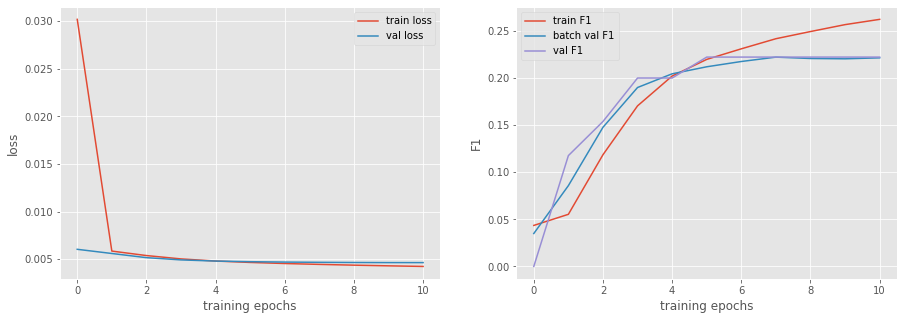

In [91]:
# number of epochs determined by the following
# plot the training and validation loss to determine if overfitting / underfitting 

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_F1 = history.history['F1_at_k']
batch_val_F1 = history.history['val_F1_at_k']
val_F1 = es.F1scores
n_epochs = len(train_loss)

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
ax[0].plot(list(range(n_epochs)), train_loss, label ='train loss')
ax[0].plot(list(range(n_epochs)), val_loss, label ='val loss')
ax[0].set_xlabel('training epochs')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(list(range(n_epochs)), train_F1, label ='train F1')
ax[1].plot(list(range(n_epochs)), batch_val_F1, label ='batch val F1')
ax[1].plot(list(range(n_epochs)), val_F1, label ='val F1')
ax[1].set_xlabel('training epochs')
ax[1].set_ylabel('F1')
ax[1].legend()
plt.show()

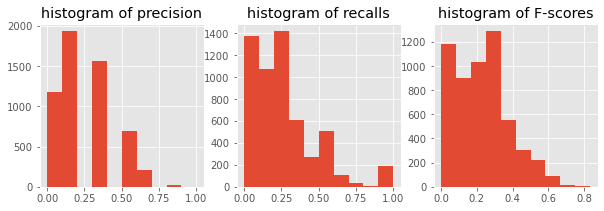

Median precision on CV set:  0.16666666666666666
Median recall on CV set:  0.2
Median F-score on CV set:  0.2222222222222222
Mean precision on CV set:  0.24142550911039656
Mean recall on CV set:  0.2479735083150312
Mean F-score on CV set:  0.22138768610365644


In [92]:
# load model with best performing validation_F1 score
model = keras.models.load_model('models/multilabel_NN/model1.h5', custom_objects= {'precision_at_k':metrics.precision_at_k,
                                                                                  'recall_at_k':metrics.recall_at_k,
                                                                                  'F1_at_k': metrics.F1_at_k})
show_histograms(model, X_cv, y_cv)

## Play around with different architectures

### model 2: larger embedding size  

* The model performance on the validation set didn't improve. 
* We'll keep the structure of model 1, which has embedding dimension 100

In [93]:
context_size = 5
embed_size = 300

model = Sequential(name = 'model2')

# embedding
model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))

# Take the mean of vectors
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean" ))
# last layer
model.add(Dense(n_words, activation = 'sigmoid', name = 'Dense'))

metrics = MetricsAtK(k = 6)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [metrics.precision_at_k,
                                                                           metrics.recall_at_k,
                                                                           metrics.F1_at_k])

model.summary()

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 5, 300)            2013600   
_________________________________________________________________
Mean (Lambda)                (None, 300)               0         
_________________________________________________________________
Dense (Dense)                (None, 6712)              2020312   
Total params: 4,033,912
Trainable params: 4,033,912
Non-trainable params: 0
_________________________________________________________________


In [94]:
# Fit model with callbacks
# early stopping
es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)

# save model
mc = ModelCheckpoint('models/multilabel_NN/model2_{epoch:02d}.h5', save_freq = 'epoch', verbose = 0)

# fit model
history = model.fit(x = X_train, y = y_train, validation_data=(X_cv, y_cv), epochs = 20, verbose = 2, callbacks = [es, mc])

model.save('models/multilabel_NN/model2.h5')

Epoch 1/20
 Validation precision: 0.0000, Validation recall: 0.0000, Validation F1: 0.0000
4098/4098 - 73s - loss: 0.0224 - precision_at_k: 0.0663 - recall_at_k: 0.0347 - F1_at_k: 0.0452 - val_loss: 0.0058 - val_precision_at_k: 0.0619 - val_recall_at_k: 0.0347 - val_F1_at_k: 0.0441
Epoch 2/20
 Validation precision: 0.1667, Validation recall: 0.1429, Validation F1: 0.1538
4098/4098 - 72s - loss: 0.0055 - precision_at_k: 0.1288 - recall_at_k: 0.0874 - F1_at_k: 0.1048 - val_loss: 0.0052 - val_precision_at_k: 0.1571 - val_recall_at_k: 0.1337 - val_F1_at_k: 0.1472
Epoch 3/20
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
4098/4098 - 72s - loss: 0.0050 - precision_at_k: 0.1776 - recall_at_k: 0.1673 - F1_at_k: 0.1803 - val_loss: 0.0049 - val_precision_at_k: 0.1895 - val_recall_at_k: 0.1958 - val_F1_at_k: 0.2031
Epoch 4/20
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
4098/4098 - 72s - loss: 0.0047 - precision_at_k: 0.2171 - re

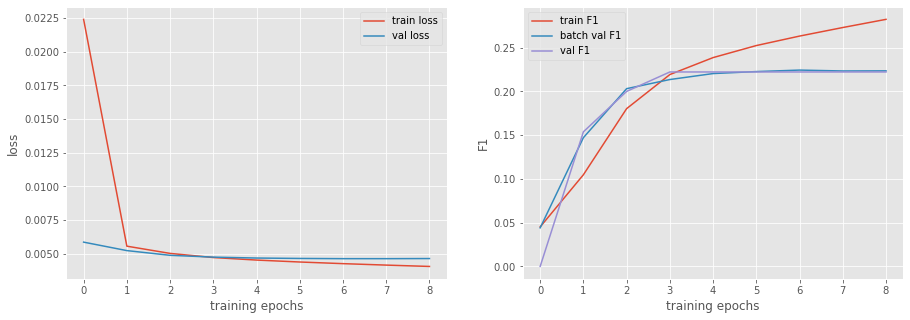

In [95]:
# number of epochs determined by the following
# plot the training and validation loss to determine if overfitting / underfitting 

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_F1 = history.history['F1_at_k']
batch_val_F1 = history.history['val_F1_at_k']
val_F1 = es.F1scores
n_epochs = len(train_loss)

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
ax[0].plot(list(range(n_epochs)), train_loss, label ='train loss')
ax[0].plot(list(range(n_epochs)), val_loss, label ='val loss')
ax[0].set_xlabel('training epochs')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(list(range(n_epochs)), train_F1, label ='train F1')
ax[1].plot(list(range(n_epochs)), batch_val_F1, label ='batch val F1')
ax[1].plot(list(range(n_epochs)), val_F1, label ='val F1')
ax[1].set_xlabel('training epochs')
ax[1].set_ylabel('F1')
ax[1].legend()
plt.show()

In [99]:
# evaluate 
y_pred = model.predict(X_cv)
print("Validation set precision: ", metrics.precision_at_k(y_cv, y_pred).numpy())
print("Validation set recall: ", metrics.recall_at_k(y_cv, y_pred).numpy())
print("Validation set F1: ", metrics.F1_at_k(y_cv, y_pred).numpy())

Validation set precision:  0.16666667
Validation set recall:  0.2
Validation set F1:  0.22222218


### model 3: Add hidden layer

In [107]:
# define model architecture
context_size = 5
embed_size = 500
model = Sequential(name = 'model3')

model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean" ))
model.add(Dense(500, activation = 'sigmoid', name = "Dense"))
model.add(Dense(n_words, activation = 'sigmoid'))

metrics = MetricsAtK(k = 6)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [metrics.precision_at_k,
                                                                           metrics.recall_at_k,
                                                                           metrics.F1_at_k])
model.summary()

Model: "model3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 5, 500)            3356000   
_________________________________________________________________
Mean (Lambda)                (None, 500)               0         
_________________________________________________________________
Dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_3 (Dense)              (None, 6712)              3362712   
Total params: 6,969,212
Trainable params: 6,969,212
Non-trainable params: 0
_________________________________________________________________


In [108]:
# Fit model with callbacks
# early stopping
es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)

# save model
mc = ModelCheckpoint('models/multilabel_NN/model3_{epoch:02d}.h5', save_freq = 'epoch', verbose = 0)

# fit model
history = model.fit(x = X_train, y = y_train, validation_data=(X_cv, y_cv), epochs = 50, verbose = 2, callbacks = [es, mc])

model.save('models/multilabel_NN/model3.h5')

Epoch 1/50
 Validation precision: 0.1667, Validation recall: 0.0833, Validation F1: 0.1111
4098/4098 - 117s - loss: 0.0069 - precision_at_k: 0.0574 - recall_at_k: 0.0307 - F1_at_k: 0.0397 - val_loss: 0.0055 - val_precision_at_k: 0.1000 - val_recall_at_k: 0.0613 - val_F1_at_k: 0.0758
Epoch 2/50
 Validation precision: 0.1667, Validation recall: 0.1429, Validation F1: 0.1667
4098/4098 - 117s - loss: 0.0053 - precision_at_k: 0.1391 - recall_at_k: 0.0988 - F1_at_k: 0.1164 - val_loss: 0.0050 - val_precision_at_k: 0.1629 - val_recall_at_k: 0.1443 - val_F1_at_k: 0.1581
Epoch 3/50
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
4098/4098 - 117s - loss: 0.0049 - precision_at_k: 0.1735 - recall_at_k: 0.1648 - F1_at_k: 0.1778 - val_loss: 0.0048 - val_precision_at_k: 0.1714 - val_recall_at_k: 0.1845 - val_F1_at_k: 0.1919
Epoch 4/50
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
4098/4098 - 117s - loss: 0.0047 - precision_at_k: 0.1941 

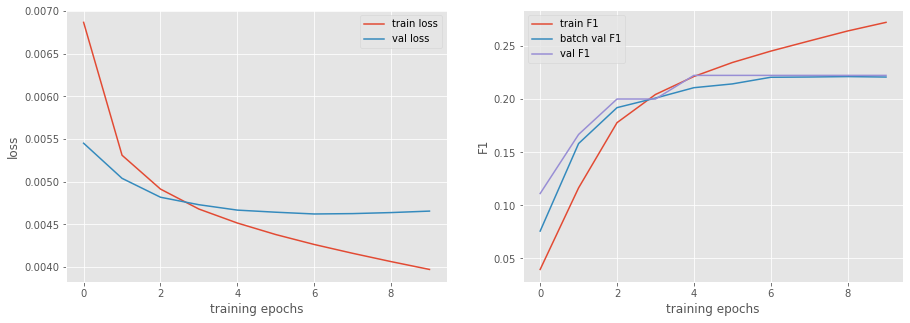

In [109]:
# number of epochs determined by the following
# plot the training and validation loss to determine if overfitting / underfitting 

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_F1 = history.history['F1_at_k']
batch_val_F1 = history.history['val_F1_at_k']
val_F1 = es.F1scores
n_epochs = len(train_loss)

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
ax[0].plot(list(range(n_epochs)), train_loss, label ='train loss')
ax[0].plot(list(range(n_epochs)), val_loss, label ='val loss')
ax[0].set_xlabel('training epochs')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(list(range(n_epochs)), train_F1, label ='train F1')
ax[1].plot(list(range(n_epochs)), batch_val_F1, label ='batch val F1')
ax[1].plot(list(range(n_epochs)), val_F1, label ='val F1')
ax[1].set_xlabel('training epochs')
ax[1].set_ylabel('F1')
ax[1].legend()
plt.show()

In [110]:
# evaluate 
y_pred = model.predict(X_cv)
print("Validation set precision: ", metrics.precision_at_k(y_cv, y_pred).numpy())
print("Validation set recall: ", metrics.recall_at_k(y_cv, y_pred).numpy())
print("Validation set F1: ", metrics.F1_at_k(y_cv, y_pred).numpy())

Validation set precision:  0.16666667
Validation set recall:  0.2
Validation set F1:  0.22222218


In [ ]:
# adding hidden layer & increasing embedding dimension doesn't improve the validation performance
# so we'll return to the original model (model 1)

## architecture without mean

In [112]:
from tensorflow.keras.layers import Flatten

In [114]:
# define model architecture
context_size = 5
embed_size = 500
model = Sequential(name = 'model4')

model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))
model.add(Flatten(name = "Flatten"))
model.add(Dense(n_words, activation = 'sigmoid', name = "Dense"))

metrics = MetricsAtK(k = 6)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = [metrics.precision_at_k,
                                                                           metrics.recall_at_k,
                                                                           metrics.F1_at_k])
model.summary()

Model: "model4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 5, 100)            671200    
_________________________________________________________________
Flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
Dense (Dense)                (None, 6712)              3362712   
Total params: 4,033,912
Trainable params: 4,033,912
Non-trainable params: 0
_________________________________________________________________


In [115]:
# Fit model with callbacks
# early stopping
es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)

# save model
mc = ModelCheckpoint('models/multilabel_NN/model4_{epoch:02d}.h5', save_freq = 'epoch', verbose = 0)

# fit model
history = model.fit(x = X_train, y = y_train, validation_data=(X_cv, y_cv), epochs = 20, verbose = 2, callbacks = [es, mc])

model.save('models/multilabel_NN/model4.h5')

Epoch 1/20
 Validation precision: 0.1667, Validation recall: 0.0909, Validation F1: 0.1176
4098/4098 - 31s - loss: 0.0201 - precision_at_k: 0.0713 - recall_at_k: 0.0384 - F1_at_k: 0.0496 - val_loss: 0.0057 - val_precision_at_k: 0.1095 - val_recall_at_k: 0.0664 - val_F1_at_k: 0.0820
Epoch 2/20
 Validation precision: 0.1667, Validation recall: 0.1667, Validation F1: 0.1818
4098/4098 - 30s - loss: 0.0053 - precision_at_k: 0.1530 - recall_at_k: 0.1182 - F1_at_k: 0.1362 - val_loss: 0.0050 - val_precision_at_k: 0.1695 - val_recall_at_k: 0.1656 - val_F1_at_k: 0.1765
Epoch 3/20
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
4098/4098 - 30s - loss: 0.0048 - precision_at_k: 0.1983 - recall_at_k: 0.1958 - F1_at_k: 0.2049 - val_loss: 0.0048 - val_precision_at_k: 0.2000 - val_recall_at_k: 0.2059 - val_F1_at_k: 0.2105
Epoch 4/20
 Validation precision: 0.1667, Validation recall: 0.2222, Validation F1: 0.2222
4098/4098 - 30s - loss: 0.0045 - precision_at_k: 0.2443 - re

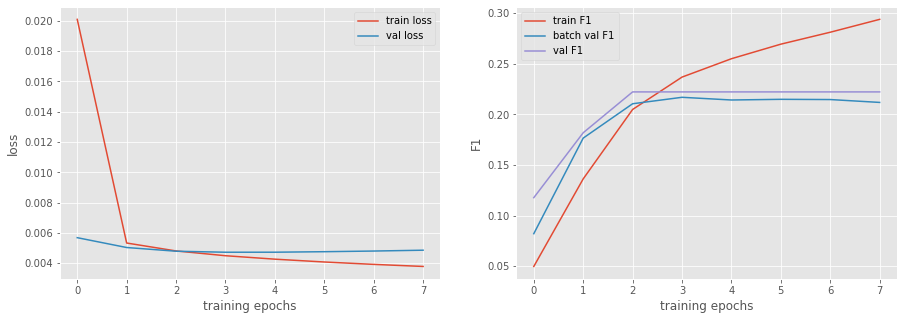

In [116]:
# number of epochs determined by the following
# plot the training and validation loss to determine if overfitting / underfitting 

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_F1 = history.history['F1_at_k']
batch_val_F1 = history.history['val_F1_at_k']
val_F1 = es.F1scores
n_epochs = len(train_loss)

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
ax[0].plot(list(range(n_epochs)), train_loss, label ='train loss')
ax[0].plot(list(range(n_epochs)), val_loss, label ='val loss')
ax[0].set_xlabel('training epochs')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(list(range(n_epochs)), train_F1, label ='train F1')
ax[1].plot(list(range(n_epochs)), batch_val_F1, label ='batch val F1')
ax[1].plot(list(range(n_epochs)), val_F1, label ='val F1')
ax[1].set_xlabel('training epochs')
ax[1].set_ylabel('F1')
ax[1].legend()
plt.show()

In [117]:
# evaluate 
y_pred = model.predict(X_cv)
print("Validation set precision: ", metrics.precision_at_k(y_cv, y_pred).numpy())
print("Validation set recall: ", metrics.recall_at_k(y_cv, y_pred).numpy())
print("Validation set F1: ", metrics.F1_at_k(y_cv, y_pred).numpy())

Validation set precision:  0.16666667
Validation set recall:  0.2
Validation set F1:  0.22222218


<b> Going back to architecture 0 </b>

In [119]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

Let's do hyperparameter tuning  
1. Tune learning rate alpha
2. Tune batch size

In [161]:
# 1. tune learning rate alpha 
# train on a subset of X_train, y_train 
idx = random.sample(range(X_train.shape[0]),50000)
X_sample = X_train[idx,:]
y_sample = y_train[idx,:]
alpha_history = []
alpha_values = []
val_precision = {}
val_recall = {}
val_f1 = {}

for i in range(10):
    # Sample parameter values from log scale, between 0.00001 to 0.1
    alpha_log = np.random.uniform(np.log10(0.0003), np.log10(0.03), 1)[0]
    alpha = round(10**alpha_log,6)

    # Define model structure
    context_size = 5
    embed_size = 100
    model = Sequential(name = "model1")
    model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))
    model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean"))
    model.add(Dense(n_words, activation = 'sigmoid', name = "Dense"))
    opt = Adam(learning_rate = alpha )
    metrics = MetricsAtK(k = 6)
    model.compile(loss =  'binary_crossentropy', optimizer = opt, metrics = [metrics.precision_at_k,
                                                                               metrics.recall_at_k,
                                                                               metrics.F1_at_k])

    # train 
    es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)
    history = model.fit(x = X_sample, y = y_sample, validation_data=(X_cv, y_cv), epochs = 20, verbose = 0, callbacks = [es])
    alpha_history.append(history)
    alpha_values.append(alpha)
    
    val_precision[i] = es.precisions
    val_recall[i] = es.recalls
    val_f1[i] = es.F1scores


 Validation precision: 0.0000, Validation recall: 0.0000, Validation F1: 0.0000
 Validation precision: 0.1667, Validation recall: 0.1000, Validation F1: 0.1250
 Validation precision: 0.1667, Validation recall: 0.1429, Validation F1: 0.1538
 Validation precision: 0.1667, Validation recall: 0.1818, Validation F1: 0.1905
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2105

 Early stopping at epoch  11

 Restoring model weights to weights from epoch  6
 Validation precision: 0.0000, Validati

 Validation precision: 0.0000, Validation recall: 0.0000, Validation F1: 0.0000
 Validation precision: 0.1667, Validation recall: 0.0500, Validation F1: 0.0769
 Validation precision: 0.1667, Validation recall: 0.0909, Validation F1: 0.1176
 Validation precision: 0.1667, Validation recall: 0.1111, Validation F1: 0.1333
 Validation precision: 0.1667, Validation recall: 0.1250, Validation F1: 0.1538
 Validation precision: 0.1667, Validation recall: 0.1429, Validation F1: 0.1667
 Validation precision: 0.1667, Validation recall: 0.1667, Validation F1: 0.1818
 Validation precision: 0.1667, Validation recall: 0.1765, Validation F1: 0.1818
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
 Validation precision: 0.1667, Validatio

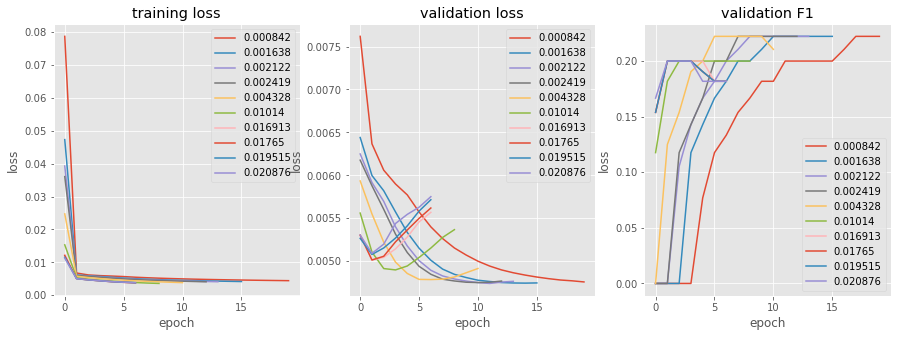

In [174]:
# plot loss curves
fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))
alpha_sort = np.argsort(alpha_values)

for i in range(10):
    train_loss = alpha_history[alpha_sort[i]].history['loss']
    ax[0].plot(train_loss, label=alpha_values[alpha_sort[i]])
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(loc = 'upper right')
ax[0].set_title('training loss')

for i in range(10):
    cv_loss = alpha_history[alpha_sort[i]].history['val_loss']
    ax[1].plot(cv_loss, label=alpha_values[alpha_sort[i]])
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(loc = 'upper right')
ax[1].set_title('validation loss')

for i in range(10):
    f1 = val_f1[alpha_sort[i]]
    ax[2].plot(f1, label=alpha_values[alpha_sort[i]])
ax[2].set_ylabel('validation F1')
ax[2].set_xlabel('epoch')
ax[2].legend(loc = 'lower right')
ax[2].set_title('validation F1')
plt.show()

In [ ]:
# why are the training loss increasing towards the end?
# It's because I performed early stopping with some patience

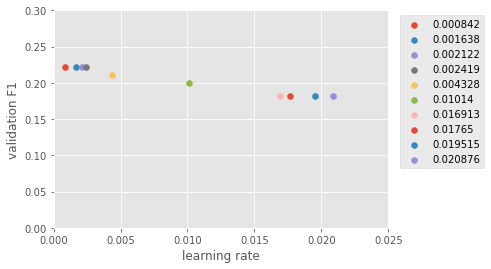

In [178]:
# plot alpha values and val F1 score at the end of training

alpha_sort = np.argsort(alpha_values)
for i in range(10):
    plt.scatter(alpha_values[alpha_sort[i]], val_f1[alpha_sort[i]][-1],
               label = alpha_values[alpha_sort[i]])
plt.xlim(0,0.025)
plt.ylim(0,0.3)
plt.xlabel('learning rate')
plt.ylabel('validation F1')
plt.legend(loc = 'upper right', bbox_to_anchor=(1.3, 1))
plt.show()

In [ ]:
# The above is showing us that the smaller learning rates will reach better Validation F1 performance

# We'll thus choose the (largest) learning rate that whose validation loss doesn't increase too quickly
# choose rate of 0.002

hyperparameter tuning  -- tune batch size

In [180]:
batch_size = [10, 20, 40, 60, 80, 100]

# train on a subset of X_train, y_train
idx = random.sample(range(X_train.shape[0]),50000)
X_sample = X_train[idx,:]
y_sample = y_train[idx,:]

val_precision = {}
val_recall = {}
val_f1 = {}

metrics = MetricsAtK(k = 6)

for batch in batch_size:

    # Define model structure
    context_size = 5
    embed_size = 100
    model = Sequential(name = "model1")
    model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))
    model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean"))
    model.add(Dense(n_words, activation = 'sigmoid', name = "Dense"))
    opt = Adam(learning_rate = 0.002)
    model.compile(loss =  'binary_crossentropy', optimizer = opt, metrics = [metrics.precision_at_k,
                                                                               metrics.recall_at_k,
                                                                               metrics.F1_at_k])

    # train 
    es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)
    history = model.fit(x = X_sample, y = y_sample, validation_data=(X_cv, y_cv), 
                        batch_size = batch,epochs = 50, verbose = 0, callbacks = [es])

    val_precision[batch] = es.precisions
    val_recall[batch] = es.recalls
    val_f1[batch] = es.F1scores

 Validation precision: 0.0000, Validation recall: 0.0000, Validation F1: 0.0000
 Validation precision: 0.1667, Validation recall: 0.1250, Validation F1: 0.1538
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2105
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2222
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2105

 Early stopping at epoch  10

 Restoring model weights to weights from epoch  5
 Validation precision: 0.0000, Validation recall: 0.0000, Validation F1: 0.0000
 Validation precision: 0.1667, Validati

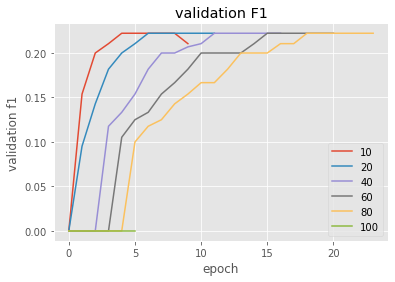

In [185]:
for i in batch_size:
    f1 = val_f1[i]
    plt.plot(f1, label=i)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("validation F1")
plt.title("validation F1")
plt.show()

In [ ]:
# The above graph shows us that a wide range of batch sizes less than 100 would be appropriate. 
# we'll choose the default batch size of 32 

# model performance on test set

In [186]:
# define model structure
context_size = 5
embed_size = 100

model = Sequential(name = "model")

# embedding
model.add(Embedding(n_words, embed_size, input_length = context_size, name = "Embedding"))

# take the mean of vectors
model.add(Lambda(lambda x: K.mean(x, axis=1), output_shape = (embed_size,), name = "Mean"))

# last layer
model.add(Dense(n_words, activation = 'sigmoid', name = "Dense"))

#metrics = MetricsAtK(6, X_cv, y_cv)

metrics = MetricsAtK(k = 6)
opt = Adam(learning_rate = 0.002 )
model.compile(loss =  'binary_crossentropy', optimizer = opt, metrics = [metrics.precision_at_k,
                                                                           metrics.recall_at_k,
                                                                           metrics.F1_at_k])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 5, 100)            671200    
_________________________________________________________________
Mean (Lambda)                (None, 100)               0         
_________________________________________________________________
Dense (Dense)                (None, 6712)              677912    
Total params: 1,349,112
Trainable params: 1,349,112
Non-trainable params: 0
_________________________________________________________________


In [187]:
# callbacks for early stopping and model saving
# early stopping
es = EarlyStoppingAtK(X_cv, y_cv, metrics, patience = 5)

# save model
mc = ModelCheckpoint('models/multilabel_NN/model_{epoch:02d}.h5', save_freq = 'epoch', verbose = 0)

# fit model
history = model.fit(x = X_train, y = y_train, validation_data=(X_cv, y_cv), 
                    batch_size = 32, epochs = 20, verbose = 2, callbacks = [es, mc])

model.save('models/multilabel_NN/model.h5')

Epoch 1/20
 Validation precision: 0.1667, Validation recall: 0.0588, Validation F1: 0.0870
4098/4098 - 31s - loss: 0.0194 - precision_at_k: 0.0634 - recall_at_k: 0.0336 - F1_at_k: 0.0436 - val_loss: 0.0058 - val_precision_at_k: 0.0790 - val_recall_at_k: 0.0421 - val_F1_at_k: 0.0542
Epoch 2/20
 Validation precision: 0.1667, Validation recall: 0.1429, Validation F1: 0.1667
4098/4098 - 31s - loss: 0.0055 - precision_at_k: 0.1323 - recall_at_k: 0.0907 - F1_at_k: 0.1082 - val_loss: 0.0051 - val_precision_at_k: 0.1610 - val_recall_at_k: 0.1337 - val_F1_at_k: 0.1499
Epoch 3/20
 Validation precision: 0.1667, Validation recall: 0.2000, Validation F1: 0.2000
4098/4098 - 31s - loss: 0.0049 - precision_at_k: 0.1816 - recall_at_k: 0.1746 - F1_at_k: 0.1865 - val_loss: 0.0048 - val_precision_at_k: 0.1857 - val_recall_at_k: 0.1985 - val_F1_at_k: 0.2042
Epoch 4/20
 Validation precision: 0.1667, Validation recall: 0.2222, Validation F1: 0.2222
4098/4098 - 31s - loss: 0.0046 - precision_at_k: 0.2238 - re

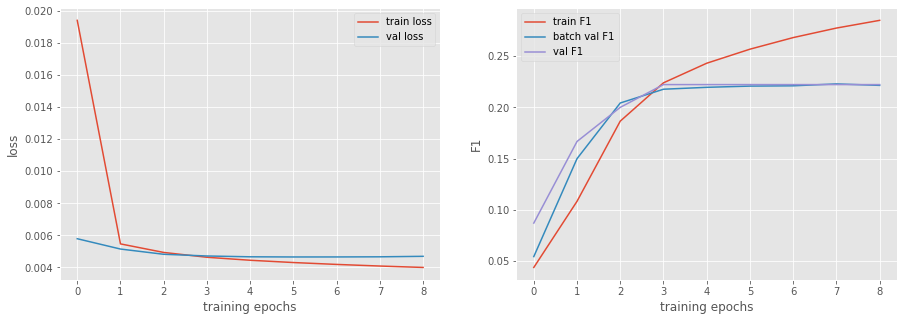

In [188]:
# number of epochs determined by the following
# plot the training and validation loss to determine if overfitting / underfitting 

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_F1 = history.history['F1_at_k']
batch_val_F1 = history.history['val_F1_at_k']
val_F1 = es.F1scores
n_epochs = len(train_loss)

fig, ax = plt.subplots(ncols = 2, figsize = (15,5))
ax[0].plot(list(range(n_epochs)), train_loss, label ='train loss')
ax[0].plot(list(range(n_epochs)), val_loss, label ='val loss')
ax[0].set_xlabel('training epochs')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(list(range(n_epochs)), train_F1, label ='train F1')
ax[1].plot(list(range(n_epochs)), batch_val_F1, label ='batch val F1')
ax[1].plot(list(range(n_epochs)), val_F1, label ='val F1')
ax[1].set_xlabel('training epochs')
ax[1].set_ylabel('F1')
ax[1].legend()
plt.show()

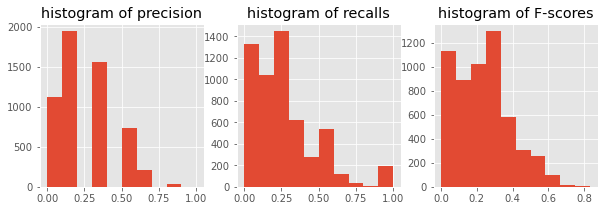

Median precision on CV set:  0.16666666666666666
Median recall on CV set:  0.2222222222222222
Median F-score on CV set:  0.2222222222222222
Mean precision on CV set:  0.2466654757651542
Mean recall on CV set:  0.2541429914747929
Mean F-score on CV set:  0.22661873785672978


In [189]:
# load model with best performing validation_F1 score
model = keras.models.load_model('models/multilabel_NN/model.h5', custom_objects= {'precision_at_k':metrics.precision_at_k,
                                                                                  'recall_at_k':metrics.recall_at_k,
                                                                                  'F1_at_k': metrics.F1_at_k})
show_histograms(model, X_cv, y_cv)

In [190]:
y_pred = model.predict(X_cv)
n_dataset = y_pred.shape[0]
pred = []
for i in range(n_dataset):
    pred_ing = y_pred[i,:].argsort()[::-1][:6].tolist()
    pred.append(pred_ing)

# for each document in CV set, create a list of missing ingredients (true ingredients)
missing_ing = []
for i in range(n_dataset):
    missing_ing.append(np.nonzero(y_cv[i,:])[0].tolist())

## compute precision, recall, F-score on the CV set 
scores = [fn.compute_scores(pred[i], missing_ing[i]) for i in range(len(pred))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

In [191]:
# print examples with high F scores 
highF = np.argsort(Fscores)[::-1][:10]
print(" ********** Example recommendations with high F scores **********")
for i in highF:
    print("==================== Example with F-score: %0.2f ===================="  %Fscores[i])
    print("---------- Existing ingredients ---------- \n", [index_to_words[item+1] for item in sampled_cv[i]])
    print("---------- Missing ingredients ---------- \n", [index_to_words[item+1] for item in target_cv[i]])
    print("---------- Recommended ingredients ---------- \n", [index_to_words[item+1] for item in pred[i]] ,"\n")

 ********** Example recommendations with high F scores **********
==================== Example with F-score: 0.83 ====================
---------- Existing ingredients ---------- 
 ['baking_soda', 'kosher_salt', 'sugar', 'whole_milk', 'buttermilk']
---------- Missing ingredients ---------- 
 ['all-purpose_flour', 'cornmeal', 'large_eggs', 'southern_us', 'baking_powder', 'unsalted_butter']
---------- Recommended ingredients ---------- 
 ['all-purpose_flour', 'southern_us', 'unsalted_butter', 'large_eggs', 'baking_powder', 'irish'] 

==================== Example with F-score: 0.80 ====================
---------- Existing ingredients ---------- 
 ['baking_soda', 'quick-cooking_oats', 'unsalted_butter', 'british', 'baking_powder']
---------- Missing ingredients ---------- 
 ['sugar', 'large_eggs', 'all-purpose_flour', 'buttermilk']
---------- Recommended ingredients ---------- 
 ['all-purpose_flour', 'sugar', 'large_eggs', 'buttermilk', 'eggs', 'baking_soda'] 

==================== Example 

In [192]:
# print examples with low F scores 
lowF = np.argsort(Fscores)[:10]
print(" ********** Example recommendations with low F scores **********")
for i in lowF:
    print("==================== Example with F-score: %0.2f ===================="  %Fscores[i])
    print("---------- Existing ingredients ---------- \n", [index_to_words[item+1] for item in sampled_cv[i]])
    print("---------- Missing ingredients ---------- \n", [index_to_words[item+1] for item in target_cv[i]])
    print("---------- Recommended ingredients ---------- \n", [index_to_words[item+1] for item in pred[i]] ,"\n")

 ********** Example recommendations with low F scores **********
==================== Example with F-score: 0.00 ====================
---------- Existing ingredients ---------- 
 ['italian', 'olive_oil', 'potatoes', 'red_pepper_flakes', 'bacon']
---------- Missing ingredients ---------- 
 ['feta_cheese_crumbles', 'salt_and_ground_black_pepper', 'eggs', 'sweet_pepper']
---------- Recommended ingredients ---------- 
 ['onions', 'garlic', 'pepper', 'ground_black_pepper', 'water', 'garlic_cloves'] 

==================== Example with F-score: 0.00 ====================
---------- Existing ingredients ---------- 
 ['basil', 'puff_pastry', 'italian', 'part-skim_mozzarella_cheese', 'fresh_basil']
---------- Missing ingredients ---------- 
 ['cooking_spray']
---------- Recommended ingredients ---------- 
 ['olive_oil', 'grated_parmesan_cheese', 'garlic', 'fresh_basil', 'garlic_cloves', 'eggs'] 

==================== Example with F-score: 0.00 ====================
---------- Existing ingredients 

In [ ]:
# are there any systematic underperformance for particular cuisine? 

In [194]:
df_CV = df.loc[cv_idx]
df_CV.reset_index(inplace = True)

df_CV = df_CV.loc[indices_cv]
df_CV.reset_index(inplace = True)

df_CV["precisions"] = precisions
df_CV["recalls"] = recalls
df_CV["Fscores"] = Fscores

df_CV.head()

,level_0,index,Unnamed: 0,id,cuisine,ingredients,document,precisions,recalls,Fscores
0,0,1,1,25693,southern_us,"['plain_flour', 'ground_pepper', 'tomatoes', '...","['plain_flour', 'ground_pepper', 'tomatoes', '...",0.333333,0.333333,0.333333
1,1,7,7,3735,italian,"['sugar', 'pistachio_nuts', 'white_almond_bark...","['sugar', 'pistachio_nuts', 'white_almond_bark...",0.166667,0.166667,0.166667
2,2,15,15,24717,indian,"['tumeric', 'vegetable_stock', 'tomatoes', 'ga...","['tumeric', 'vegetable_stock', 'tomatoes', 'ga...",0.333333,0.333333,0.333333
3,3,24,24,49136,italian,"['marinara_sauce', 'flat_leaf_parsley', 'olive...","['marinara_sauce', 'flat_leaf_parsley', 'olive...",0.166667,0.200000,0.181818
4,4,38,38,17610,southern_us,"['green_onions', 'cream_cheese', 'shredded_che...","['green_onions', 'cream_cheese', 'shredded_che...",0.000000,0.000000,0.000000


In [195]:
# compute median scores for each cuisine
df_CV[["cuisine", "precisions", "recalls", "Fscores"]].groupby("cuisine").median().sort_values(by='Fscores', ascending = False)

,precisions,recalls,Fscores
cuisine,,,
korean,0.333333,0.272727,0.285714
moroccan,0.333333,0.200000,0.250000
chinese,0.333333,0.222222,0.250000
filipino,0.166667,0.250000,0.250000
russian,0.333333,0.250000,0.250000
indian,0.333333,0.200000,0.245000
spanish,0.166667,0.250000,0.235294
irish,0.166667,0.250000,0.235294
italian,0.166667,0.250000,0.222222


# 5. Comparison of the models 

* Compare the performance of various models on the cross-validation set

* Based on the performance of the recommenders on the cross-validation set, the recommender based on association rule mining performs the best.   
* Note, however, that extracting the rules according to the apriori algorithm takes a long time. This may not be that big of an issue for the recommender once it learns all the rules from the training set.  
* The recommender based on association rule mining takes longer to recommend ingredients than the other two recommenders. Again, this may not be that big of an issue for the application itself when users make a single query. 

In [ ]:
# So far, the models we looked at are the following
# NMF-based recommender
# word-embedding based recommender
# association-rule mining based recommender

# Let's compare the performance of these models using k-fold cross-validation
# report the performance on the test set 

In [ ]:
# define the models to compare

In [ ]:
# define the set to perform k-fold cross-validation on 
# For this step, combine the training and cv set

# load train, cv, test data index
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
train_idx = list(f.get("train_idx"))
cv_idx = list(f.get("cv_idx"))
test_idx = list(f.get("test_idx"))
f.close()

# define the data used for kfold cross-validation 
kfold_idx = train_idx + cv_idx
kfold_doc = [documents[i] for i in kfold_idx]

# perform 10 fold CV 

# get existing ingredients and the remaining ingredients to be predicted
existing_ing, missing_ing = sample_ingredients(kfold_doc, 5)


In [ ]:
# compare models

In [ ]:
# report performance on the test set 

# 6. Future directions / To Do

* Revisit the metric for evaluating the models. 
* Deal with bias in dataset by grabbing more data. 
* Consider combining multiple models.
* Serendipity / diversity / novelty of the system?
* Build app.